# Why embed networks?

Networks by themselves are interesting objects, but a network is not how we traditionally organize data in machine learning. In almost any ML algorithm - whether you're using a neural network, or a decision tree, or whether your goal is to classify datapoints or to predict a value using regression - you'll see data organized into a matrix, where the rows represent observations and the columns represent features, or variables. Each data point, then, is traditionally represented as a single point in d-dimensional space: each column gets its own axis in a plot, and each row is a single datapoint.

For example, the data below is organized traditionally. On the left is the data matrix; you can see that there are two feature columns, one for each axis. The x-column contains the x-coordinates for each datapoint, and the x-column contains the y-coordinates for each data point. We can see two clusters of data numerically.

On the right is the same data, but plotted in Euclidean space. Each column of the data matrix gets its own axis of the plot, so that the x and y axis location of the $i_{th}$ datapoint in the scatterplot is the same as the x and y values of the $i_{th}$ row of the data matrix. We can see the two clusters of data geometrically.

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np

# make the data
centers = np.array([[-2, -2], 
                    [2, 2]])
X, y = make_blobs(n_samples=10, cluster_std=0.5,
                  centers=centers, shuffle=False)

# convert data into a DataFrame
data = pd.DataFrame(X, columns=["x", "y"])

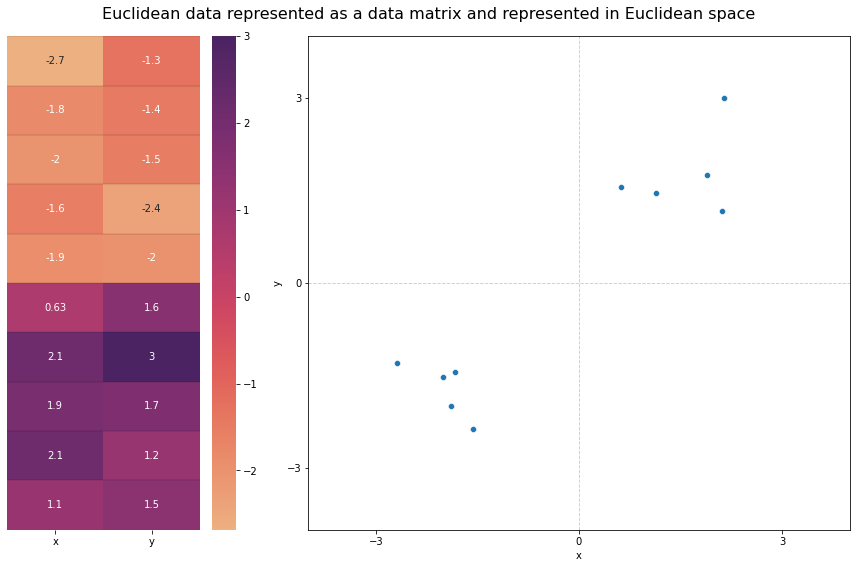

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# setup
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 3)
axm = fig.add_subplot(gs[0])
axs = fig.add_subplot(gs[1:])
cmap="flare"

# plot left
hm = sns.heatmap(data, ax=axm, yticklabels=False, 
                 cmap=cmap, annot=True, cbar=True)
hm.hlines(range(len(data)), *hm.get_xlim(), colors='k', alpha=.1)

# plot right
plot = sns.scatterplot(data=data, x='x', y='y', legend=False, ax=axs)

# lines
max_ = int(data.values.max()) + 1
plot.vlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)
plot.hlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)

# ticks
plot.xaxis.set_major_locator(plt.MaxNLocator(3))
plot.yaxis.set_major_locator(plt.MaxNLocator(3))

# set axis bounds
lim = (-max_, max_)
plot.set(xlim=lim, ylim=lim)

# title, etc
plt.suptitle("Euclidean data represented as a data matrix and represented in Euclidean space", fontsize=16)
plt.tight_layout()

Most machine learning methods require our data to be organized like this. For example, with the data above, we could use scikit-learn to perform simple K-Means Clustering to find two groups of data points:

In [3]:
from sklearn.cluster import KMeans

predicted_labels = KMeans(n_clusters=2).fit_predict(X)
predicted_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

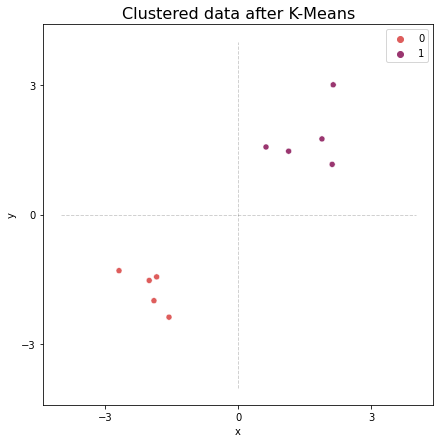

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))

# plot right
plot = sns.scatterplot(data=data, x='x', y='y', ax=ax, 
                       hue=predicted_labels, palette=cmap)

# lines
plot.vlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)
plot.hlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)

# ticks
plot.xaxis.set_major_locator(plt.MaxNLocator(3))
plot.yaxis.set_major_locator(plt.MaxNLocator(3))

# title
plot.set_title("Clustered data after K-Means", fontsize=16);

Network-valued data is different. Take the Stochastic Block Model below, shown as both a layout plot and an adjacency matrix. Say your goal is to view the nodes as particular datapoints, and you'd like to cluster the data in the same way you clustered the Euclidean data above. Intuitively, you'd expect to find two groups: one for the first set of heavily connected nodes, and one for the second set. Unfortunately, traditional machine learning algorithms won't work here, because network data doesn't live in the traditional rows-as-observations, columns-as-features format.

In [5]:
import networkx as nx
from graspologic.simulations import sbm
np.random.seed(1)

p = np.array([[.9, .1],
              [.1, .9]])
A, labels = sbm([25, 25], p, return_labels=True)

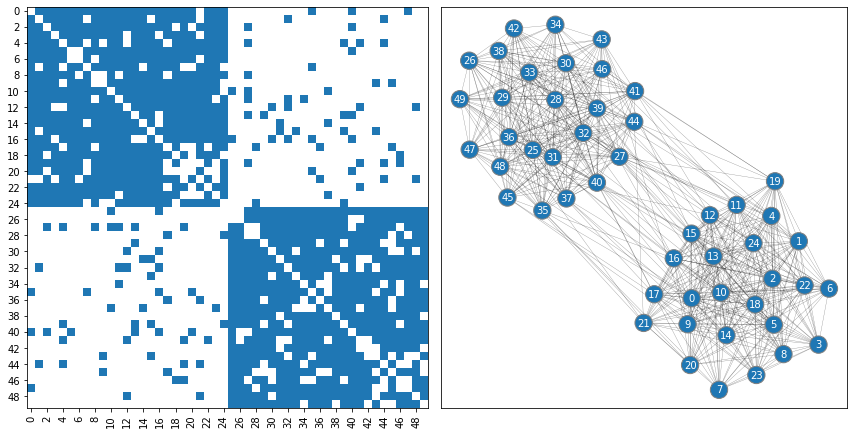

In [6]:
from graspologic.plot import heatmap

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# heatmap
hm = heatmap(A, ax=axs[0], cbar=False, 
        cmap=[(1, 1, 1), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)], 
        center=None, xticklabels=2, yticklabels=2)
sns.despine(bottom=False, left=False, top=False, right=False)

G = nx.Graph(A)
rgb = np.atleast_2d((0.12156862745098039, 0.4666666666666667, 0.7058823529411765))
colors = np.repeat(rgb, len(A), axis=0)

pos = nx.spring_layout(G)

options = {"edgecolors": "tab:gray", "node_size": 300}
nx.draw_networkx_nodes(G, node_color=colors, pos=pos, ax=axs[1], **options)
nx.draw_networkx_edges(G, alpha=.5, pos=pos, width=.3, ax=axs[1])
nx.draw_networkx_labels(G, pos, font_size=10, font_color="white", ax=axs[1])

plt.tight_layout()

You, of course, *can* make up methods which work directly on networks - algorithms which run by traversing along edges, for instance, or which use network statistics like node degree to learn, and so on - but to be able to use the entire toolbox that machine learning offers, without having to design special network-specific methods, you'd like to be able to figure out a way to *represent* networks in Euclidean space, as tabular data. 

## High Dimensionality of Network Data

The other problem with network data is its high dimensionality. When you view the nodes as dimensions, each node has a number of dimensions equal to its possible edge count - so if you have n nodes, each node has n-1 dimensions. 

This can get to a fairly unmanageable number of dimensions when you have a lot of nodes, largely because of a machine learning concept called the *curse of dimensionality*. 

```{admonition} The Curse of Dimensionality
Our intuition often fails when objects have a lot of features -- meaning, objects that, when you think of them geometrically, are points in very high-dimensional space. 

For example, pick a point randomly in a 10,000-dimensional unit hypercube (meaning, a $1 \times 1 \times \dots \times 1$ cube, with ten thousand 1s). You can also just think of these point as a vector with 10,000 elements, each of which has a value between 0 and 1. There's a probability greater than 99.999999% that the point will be located a distance less than .001 from a border. This probability is only 0.4% in a unit square. This leads to a fun fact: pretty much anyone you know is probably an extremist in at least one dimension.

An even bigger shocker: if you pick two random points in a unit square with two dimensions, they'll be on average 0.52 units of distance away from each other. However, if you pick two random points in a unit hypercube with a million dimensions, they'll be around 408 units away from each other.

What this comes down to is that almost every point in ultra-high dimensions is extremely lonely, hugging the edge of the space it lives in by itself. {cite:t}`homl`
```

Network embedding methods, much like traditional dimensionality reduction methods in machine learning like Principle Component Analysis (PCA), allow us to move down to a much more manageable number of dimensions while still preserving information about the network.

## Spectral Embedding

One of the primary embedding tools we'll use in this book is called *spectral embedding* {cite:t}`spectraltutorial`. You'll see spectral embedding and variations on it repeatedly, both throughout this section and when we get into applications, so it's worth taking the time to understand spectral embedding deeply. This method is similar in spirit to PCA, and we'll need to get into a bit of linear algebra to understand how it works.

The basic idea behind Spectral Embedding is to take a network, optionally take its Laplacian, and then find the eigenvectors corresponding to the $d$ largest eigenvalues, depending on how many dimensions ($d$) you'd like to embed your network down to. The new matrix will be organized traditionally, with rows (observations) corresponding to nodes, and columns (features) corresponding to the top eigenvectors of the network.

/Users/alex/.pyenv/versions/3.8.5/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


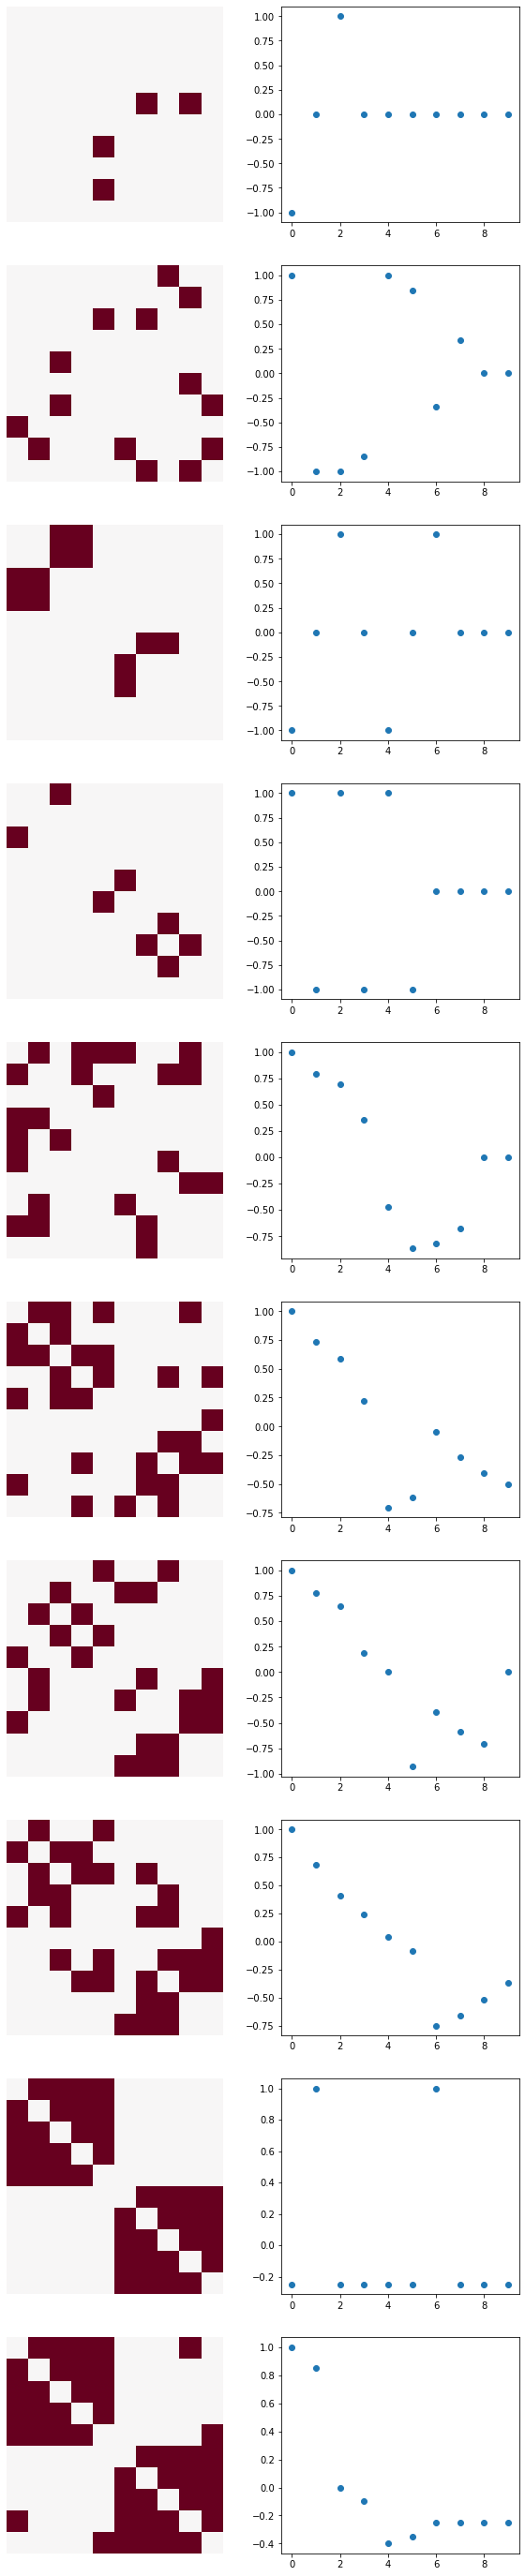

In [10]:
import matplotlib.pyplot as plt
from graspologic.utils import to_laplacian

def make_sbm(p, q):
    P = np.array([[p, q],
                  [q, p]])
    A = sbm([5, 5], P)
    return A

n_networks = 10
ps = np.linspace(0, 1, num=n_networks)
fig, axs = plt.subplots(n_networks, 2, figsize=(10,5*n_networks))
for i, p in enumerate(ps):
    A = make_sbm(p, .1)
    L = to_laplacian(A)
    eigvals = np.linalg.eigvals(L)
    heatmap(A, ax=axs[i, 0], cbar=False)
    axs[i, 1].scatter(np.arange(len(eigvals)), eigvals)


In [8]:
make_sbm(0, 0)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Adjacency Spectral Embedding

### Laplacian Spectral Embedding

- calculation of similarity between two objects (e.g., cosine or euclidean distance)